In [143]:
""" 
SOAR Offline Laptime Optimization for Reference Trajectory Generation
AA 203/273 Spring 2024
Andrew Wang, Bryan Yang
"""
import numpy as np
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
from agents import BicycleVehicle
from config import *

In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
# Set up track for optimization
veh_config = get_vehicle_config()
scene_config = get_scene_config(track_type=L_TRACK)
veh_constraints = get_vehicle_opt_constraints(veh_config, scene_config)
track = scene_config["track"]

In [198]:
print(track.name)

L TRACK w/Straight 100, Curve Radius 50


In [199]:
def compute_raceline(track, vehicle_config, vehicle_constraints):

    #SYSTEM STATES:  vx=x[0],  vy=x[1], wz=x[2] ,e_psi=x[3], t=x[4], e_y=x[5]
    #SYSTEM INPUTS:  ax[m/s^2]=u0, steering(rad)=u1
    #INDEPENDENT VARIABLE IS s (space)

    lf = vehicle_config["lf"]
    lr = vehicle_config["lr"]

    mass = vehicle_config["m"]
    Iz = vehicle_config["Iz"]

#     tire_model = vehicle_config.tire_model

#     mu = vehicle_config.wheel_friction
#     Br = vehicle_config.pacejka_b_rear
#     Bf = vehicle_config.pacejka_b_front
#     Cr = vehicle_config.pacejka_c_rear
#     Cf = vehicle_config.pacejka_c_front
#     Dr = vehicle_config.pacejka_d_rear
#     Df = vehicle_config.pacejka_d_front

#     xu_ub = vehicle_constraints['xu_ub']
#     xu_lb = vehicle_constraints['xu_lb']
#     du_ub = vehicle_constraints['du_ub']
#     du_lb = vehicle_constraints['du_lb']
    c_alpha_f = vehicle_config["c"]
    c_alpha_r = vehicle_config["c"]
    
    Cd = veh_config["Cd"]
    SA = veh_config["SA"]
    
    v_long_max = vehicle_constraints["ub_vx"]
    v_long_min = vehicle_constraints["lb_vx"]
    v_tran_max = vehicle_constraints["ub_vy"]
    v_tran_min = vehicle_constraints["lb_vy"]
    psidot_max = vehicle_constraints["ub_omega"]
    psidot_min = vehicle_constraints["lb_omega"]
    e_psi_max = vehicle_constraints["ub_epsi"]
    e_psi_min = vehicle_constraints["lb_epsi"]
    e_y_max = vehicle_constraints["ub_ey"]
    e_y_min = vehicle_constraints["lb_ey"]
    steer_max = vehicle_constraints["ub_delta"]
    steer_min = vehicle_constraints["lb_delta"]

    a_max = vehicle_config["max_accel"]
    a_min = -vehicle_config["max_accel"]
    steer_rate_max = vehicle_config["max_steer_rate"]
    steer_rate_min = -vehicle_config["max_steer_rate"]

#     a_rate_max = du_ub.u_a
#     a_rate_min = du_lb.u_a


    print('=================== Raceline computation ===================')
    print('Track name: %s' % track.name)
    print('     - length: %g m' % track.total_len)
    print('     - width: %g m' % (track.half_width*2))
    print('Vehicle configuration:')
    print('     - center of mass to front axle: %g m' % lf)
    print('     - center of mass to rear axle: %g m' % lr)
    print('     - mass: %g kg' % mass)
    print('     - yaw inertia: %g kg m^2' % Iz)
    print('     - Drag Coefficient: %g' % Cd)
    print('     - frontal area: %g m^2' % SA)
#     print('     - tire model: %s' % tire_model)
#     print('     - tire friction coefficient: %g' % mu)
#     print('     - Front tires:')
#     print('         - B: %g' % Bf)
#     print('         - C: %g' % Cf)
#     print('         - D: %g' % Df)
#     print('     - Rear tires:')
#     print('         - B: %g' % Br)
#     print('         - C: %g' % Cr)
#     print('         - D: %g' % Dr)
    print('Vehicle input constraints:')
    print('     - max acceleration: %g m/s^2' % a_max)
    print('     - min acceleration: %g m/s^2' % a_min)
    print('     - max steering angle: %g rad' % steer_max)
    print('     - min steering angle: %g rad' % steer_min)
    print('Vehicle state constraints:')
    print('     - max longitudinal velocity: %g m/s' % v_long_max)
    print('     - min longitudinal velocity: %g m/s' % v_long_min)
    print('     - max lateral velocity: %g m/s' % v_tran_max)
    print('     - min lateral velocity: %g m/s' % v_tran_min)
    print('     - max yaw rate: %g rad/s' % psidot_max)
    print('     - min yaw rate: %g rad/s' % psidot_min)
    print('============================================================')

    model = m = ConcreteModel()
    m.sf = Param(initialize=track.total_len)
    m.s = ContinuousSet(bounds=(0, m.sf))                             #s

    m.u0 = Var(m.s, bounds=(a_min, a_max), initialize=0)
#     m.u1 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)
    m.u1 = Var(m.s, bounds=(steer_rate_min, steer_rate_max), initialize=0)
    m.alpha_f = Var(m.s, initialize=0)
    m.alpha_r = Var(m.s, initialize=0)
    m.Fyf = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.Fyr = Var(m.s,bounds=(-mass*9.8, mass*9.8), initialize=0)
    m.x0 = Var(m.s, bounds=(v_long_min, v_long_max), initialize=8) #vx
    m.x1 = Var(m.s, bounds=(v_tran_min, v_tran_max), initialize=1)    #vy
    m.x2 = Var(m.s, bounds=(psidot_min, psidot_max), initialize=0)    #omega
    m.x3 = Var(m.s, bounds=(e_psi_min, e_psi_max), initialize=0)    #epsi
    def _t_init(m, s):
        return s/track.total_len * 30
    m.x4 = Var(m.s, bounds=(0, 200), initialize=_t_init)                  #t
    m.x5 = Var(m.s, bounds=(e_y_min, e_y_max), initialize=7)          #ey
    m.x6 = Var(m.s, bounds=(steer_min, steer_max), initialize=0)      #delta

    m.dx0ds = DerivativeVar(m.x0, wrt=m.s)
    m.dx1ds = DerivativeVar(m.x1, wrt=m.s)
    m.dx2ds = DerivativeVar(m.x2, wrt=m.s)
    m.dx3ds = DerivativeVar(m.x3, wrt=m.s)
    m.dx4ds = DerivativeVar(m.x4, wrt=m.s)
    m.dx5ds = DerivativeVar(m.x5, wrt=m.s)
    m.dx6ds = DerivativeVar(m.x6, wrt=m.s)
    m.du0ds = DerivativeVar(m.u0, wrt=m.s)
    m.du1ds = DerivativeVar(m.u1, wrt=m.s)

    # to avoid divide by 0
    eps=0.000001

    #Objective function
#     m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.du1ds[i]**2 for i in m.s), sense=minimize)
    m.obj = Objective(expr=m.x4[m.sf], sense=minimize) # + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.u1[i]**2 for i in m.s), sense=minimize)
#     m.obj = Objective(expr=m.x4[m.sf] + 0.01*sum(m.du0ds[i]**2 for i in m.s) + 0.01*sum(m.u1[i]**2 for i in m.s), sense=minimize)
    # ways to tune the cost:
        # penalize u1
        # penalize u2
        # penalize u1 and u2
        # vary the penalizations on u1 and u2
        # penalize the input rate
    # to do: write this optimization problem as a function that gets called
    # different arguments will choose a different objective tuning
    # function output should be the DF, then we can store them all

    #sideslip and lateral force
    def _alphafc(m, s):
#         return m.alpha_f[s] == m.u[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
        # alpha = delta - atan((vy+lf*w)/vx)
        return m.alpha_f[s] == m.x6[s] - atan((m.x1[s] + lf * m.x2[s])/ (m.x0[s]))
    m.c4 = Constraint(m.s, rule=_alphafc)
    def _alpharc(m, s):
        # alpha = - atan((vy-lr*w)/vx)
        return m.alpha_r[s] == -atan((m.x1[s] - lr * m.x2[s])/ (m.x0[s]))
    m.c3 = Constraint(m.s, rule=_alpharc)

#     if tire_model == 'linear':
#         def _Fyfc(m, s):
#             return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
#         m.c2 = Constraint(m.s, rule=_Fyfc)
#         def _Fyrc(m, s):
#             return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
#         m.c1 = Constraint(m.s, rule=_Fyrc)
#     elif tire_model == 'pacejka':
#         def _Fyfc(m, s):
#             return m.Fyf[s] ==  Df * sin(Cf * atan(Bf * m.alpha_f[s]))
#         m.c2 = Constraint(m.s, rule=_Fyfc)
#         def _Fyrc(m, s):
#             return m.Fyr[s] ==  Dr * sin(Cr * atan(Br * m.alpha_r[s]))
#         m.c1 = Constraint(m.s, rule=_Fyrc)
        
    def _Fyfc(m, s):
#         return m.Fyf[s] ==  Df * Cf * Bf * m.alpha_f[s]
        return m.Fyf[s] ==  c_alpha_f * m.alpha_f[s]
    m.c2 = Constraint(m.s, rule=_Fyfc)
    def _Fyrc(m, s):
#         return m.Fyr[s] ==  Dr * Cr * Br * m.alpha_r[s]
        return m.Fyr[s] ==  c_alpha_r * m.alpha_r[s]
    m.c1 = Constraint(m.s, rule=_Fyrc)

    #Differential model definition
    def _x0dot(m, s):
        cur = track.getCurvature(s)
        # print(cur)
        # dvx/ds = vxdot/sdot = (a - (Fd/m + Fyfsin(delta)/m + omega*vy)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
#         return m.dx0ds[s] == m.u0[s] - (m.Fyf[s]*sin(m.x6[s]/mass) - (0.5*Cd*SA*m.x0[s]**2/mass) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
        return m.dx0ds[s] == m.u0[s] - (m.Fyf[s]*sin(m.x6[s]/mass) + m.x2[s]*m.x1[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x0dot = Constraint(m.s, rule=_x0dot)

    def _x1dot(m, s):
        cur = track.getCurvature(s)
        # dvy/ds = vydot/sdot = 1/m*(Fyfcos(delta)+Fyr) + omega*vx)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx1ds[s] == (1 / mass * (m.Fyf[s]*cos(m.x6[s]) + m.Fyr[s]) - m.x2[s]*m.x0[s])*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x1dot = Constraint(m.s, rule=_x1dot)

    def _x2dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = wdot/sdot = 1/Iz*(lf*Fyfcos(delta) - lrFyr)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx2ds[s] == (1 / Iz *(lf*m.Fyf[s] * cos(m.x6[s]) - lr * m.Fyr[s]) )*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x2dot = Constraint(m.s, rule=_x2dot)

    def _x3dot(m, s):
        cur = track.getCurvature(s)
        # dw/ds = epsidot/sdot = (omega - kappa*sdot)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) = omega*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi)) - kappa
        return m.dx3ds[s] == ( m.x2[s]*(1 - cur * m.x5[s])/(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])) - cur)
    m.x3dot = Constraint(m.s, rule=_x3dot)

    def _x4dot(m, s):
        cur = track.getCurvature(s)
        # dt/ds = 1/sdot = (1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx4ds[s] == ((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x4dot = Constraint(m.s, rule=_x4dot)

    def _x5dot(m, s):
        cur = track.getCurvature(s)
        # dey/ds = eydot/sdot = (vxsin(epsi) + vycos(epsi))*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx5ds[s] == (m.x0[s] * sin(m.x3[s]) + m.x1[s] * cos(m.x3[s]))*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x5dot = Constraint(m.s, rule=_x5dot)
    
    def _x6dot(m, s):
        cur = track.getCurvature(s)
        # ddelta/ds = deltadot/sdot = (ddelta)*(1-kappa*ey) / (eps+vx*cos(epsi) - vy*sin(epsi))
        return m.dx6ds[s] == m.u1[s]*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
    m.x6dot = Constraint(m.s, rule=_x6dot)

#     # rate constraints on acceleration
#     def _u0dotmax(m, s):
#         cur = track.getCurvature(s)
#         return m.du0ds[s] <= a_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotub = Constraint(m.s, rule=_u0dotmax)
#     def _u0dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du0ds[s] >= a_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i0dotlb = Constraint(m.s, rule=_u0dotmin)

#     rate constraints on steering
#     def _u1dotmax(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] <= steer_rate_max*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotub = Constraint(m.s, rule=_u1dotmax)
#     def _u1dotmin(m, s):
#         cur = track.get_curvature(s)
#         return m.du1ds[s] >= steer_rate_min*((1 - cur * m.x5[s]) /(eps+m.x0[s] * cos(m.x3[s]) - m.x1[s] * sin(m.x3[s])))
#     m.i1dotlb = Constraint(m.s, rule=_u1dotmin)

    # inital and terminal conditions
    def _init(m):
        yield m.x0[0] == m.x0[track.total_len] #vx
        yield m.x1[0] == m.x1[track.total_len] #vy
        yield m.x2[0] == m.x2[track.total_len] #w
        yield m.x3[0] == m.x3[track.total_len] #epsi
        yield m.x4[0] == 0 #t
        yield m.x5[0] == m.x5[track.total_len] #ey
        yield m.x6[0] == m.x6[track.total_len] #delta
#         yield m.x0[0] == 0 #vx
#         yield m.x1[0] == 0 #vy
#         yield m.x2[0] == 0 #w
#         yield m.x3[0] == 0 #epsi
#         yield m.x4[0] == 0 #t
#         yield m.x5[0] == 0 #ey
#         yield m.x6[0] == 0 #delta
    m.init_conditions = ConstraintList(rule=_init)

    # Discretize model using radau or finite difference collocation
    TransformationFactory('dae.collocation').apply_to(m, nfe=100, ncp=10, scheme='LAGRANGE-LEGENDRE') #STANDARD METHOD

    # Solve algebraic model
    solver = SolverFactory('ipopt')
    # Solver options
    solver.options['max_iter'] = 8000
    print("new")
    results = solver.solve(m,tee=True)

    # Evaluate solution at discretization points
    s_vec = list(sorted(m.s.data()))

    raceline = {'t': np.zeros(len(s_vec)),
                'x' : np.zeros(len(s_vec)),
                'y' : np.zeros(len(s_vec)),
                'psi' : np.zeros(len(s_vec)),
                's' : np.zeros(len(s_vec)),
                'e_y' : np.zeros(len(s_vec)),
                'e_psi' : np.zeros(len(s_vec)),
                'delta' : np.zeros(len(s_vec)),
                'v_long' : np.zeros(len(s_vec)),
                'v_tran' : np.zeros(len(s_vec)),
                'psidot' : np.zeros(len(s_vec)),
                'u_a': np.zeros(len(s_vec)),
                'u_s': np.zeros(len(s_vec))}

    for j in range(len(s_vec)):
        s = s_vec[j]
        
        vx = value(m.x0[s])
        vy = value(m.x1[s])
        w = value(m.x2[s])
        epsi = value(m.x3[s])
        t = value(m.x4[s])
        ey = value(m.x5[s])
        delta = value(m.x6[s])
        a = value(m.u0[s])
        ddelta = value(m.u1[s])
        
        cl_state = np.array([s, ey, epsi, vx, vy, w, delta])
        global_state = track.CLtoGlobal(cl_state)
        x, y, theta, vx_g, vy_g, w_g, delta_g = global_state

        raceline['t'][j] = t
        raceline['v_long'][j] = vx
        raceline['v_tran'][j] = vy
        raceline['psidot'][j] = w
        raceline['s'][j] = s
        raceline['e_y'][j] = ey
        raceline['e_psi'][j] = epsi
        raceline['delta'][j] = delta
        raceline['x'][j] = x
        raceline['y'][j] = y
        raceline['psi'][j] = theta
        raceline['u_a'][j] = a
        raceline['u_s'][j] = ddelta

    return raceline



In [ ]:
raceline = compute_raceline(track, veh_config, veh_constraints)

=================== Raceline computation ===================
Track name: L TRACK w/Straight 100, Curve Radius 50
     - length: 671.239 m
     - width: 30 m
Vehicle configuration:
     - center of mass to front axle: 2.5 m
     - center of mass to rear axle: 2 m
     - mass: 800 kg
     - yaw inertia: 1800 kg m^2
     - Drag Coefficient: 0.56
     - frontal area: 2 m^2
Vehicle input constraints:
     - max acceleration: 10 m/s^2
     - min acceleration: -10 m/s^2
     - max steering angle: 0.5 rad
     - min steering angle: -0.5 rad
Vehicle state constraints:
     - max longitudinal velocity: 10 m/s
     - min longitudinal velocity: 0 m/s
     - max lateral velocity: 2 m/s
     - min lateral velocity: -2 m/s
     - max yaw rate: 1 rad/s
     - min yaw rate: -1 rad/s
new
Ipopt 3.13.4: max_iter=8000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open sour

  68  6.0755857e+01 2.11e-01 1.16e+06  -1.0 4.74e+02   0.8 6.46e-04 5.27e-03h  1
  69  6.0760750e+01 2.11e-01 1.19e+06  -1.0 4.63e+02   1.3 1.94e-03 6.81e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  6.0805217e+01 2.11e-01 1.20e+06  -1.0 4.14e+02   0.8 1.85e-03 6.36e-04h  1
  71  6.0908240e+01 2.11e-01 1.18e+06  -1.0 4.63e+02   1.2 5.38e-04 1.49e-03h  1
  72  6.0925280e+01 2.10e-01 1.18e+06  -1.0 1.21e+03   0.7 6.85e-07 3.12e-04f  1
  73  6.1483056e+01 2.09e-01 1.14e+06  -1.0 4.29e+02   1.2 5.46e-03 8.29e-03h  1
  74  6.1489347e+01 2.09e-01 1.15e+06  -1.0 3.95e+02   1.6 5.38e-04 9.46e-05h  1
  75  6.1493489e+01 2.09e-01 1.23e+06  -1.0 3.64e+02   1.1 5.63e-03 5.36e-05h  1
  76  6.1529093e+01 2.09e-01 1.23e+06  -1.0 4.09e+02   1.5 6.19e-04 4.78e-04h  1
  77  6.1536522e+01 2.09e-01 1.23e+06  -1.0 3.85e+02   1.0 5.78e-04 9.74e-05h  1
  78  6.1554789e+01 2.09e-01 1.23e+06  -1.0 3.96e+02   1.5 1.90e-06 2.44e-04h  1
  79  6.1772557e+01 2.08e-01

 161  8.4545429e+01 7.93e-02 3.25e+03  -1.0 6.14e+02  -2.4 1.35e-02 5.14e-03f  1
 162  8.5440031e+01 7.78e-02 1.89e+03  -1.0 4.48e+02  -2.0 1.95e-04 1.86e-02f  1
 163  8.5476269e+01 7.77e-02 2.18e+03  -1.0 4.76e+02  -1.5 1.29e-02 7.20e-04h  1
 164  8.6137394e+01 7.68e-02 1.28e+03  -1.0 2.50e+02  -1.1 2.06e-03 1.27e-02h  1
 165  8.6228531e+01 7.66e-02 1.21e+03  -1.0 2.14e+02  -0.7 2.53e-03 1.89e-03h  1
 166  8.6474243e+01 7.62e-02 1.24e+03  -1.0 2.51e+02  -1.2 7.91e-03 5.13e-03h  1
 167  8.6479689e+01 7.62e-02 2.57e+03  -1.0 1.46e+02  -0.7 3.40e-03 1.10e-04h  1
 168  8.6913485e+01 7.56e-02 1.36e+03  -1.0 3.40e+02  -1.2 5.07e-03 8.48e-03f  1
 169  8.7078792e+01 7.53e-02 1.24e+03  -1.0 2.68e+02  -0.8 2.29e-03 3.19e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  8.7188830e+01 7.52e-02 2.02e+03  -1.0 3.27e+02  -1.3 9.94e-03 2.13e-03h  1
 171  8.7200905e+01 7.51e-02 4.74e+03  -1.0 3.89e+02  -0.8 2.62e-03 2.19e-04h  1
 172  8.7743276e+01 7.44e-02

 254  9.6920338e+01 6.04e-02 1.48e+05  -1.0 5.59e+02   0.2 7.13e-03 1.12e-03h  1
 255  9.7005332e+01 6.02e-02 1.48e+05  -1.0 1.76e+02   0.6 9.57e-04 2.43e-03h  1
 256  9.7009065e+01 6.02e-02 1.46e+05  -1.0 1.66e+02   1.1 2.27e-03 1.05e-04h  1
 257  9.7101256e+01 6.01e-02 1.46e+05  -1.0 1.79e+02   0.6 9.27e-05 2.64e-03h  1
 258  9.7103709e+01 6.01e-02 1.46e+05  -1.0 1.67e+02   1.0 5.69e-04 6.92e-05h  1
 259  9.7300217e+01 5.97e-02 1.45e+05  -1.0 1.81e+02   0.5 8.25e-05 5.65e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  9.7321947e+01 5.97e-02 1.45e+05  -1.0 1.66e+02   1.0 6.70e-04 6.21e-04h  1
 261  9.7449788e+01 5.95e-02 1.45e+05  -1.0 1.79e+02   0.5 2.97e-03 3.76e-03h  1
 262  9.7586161e+01 5.92e-02 1.45e+05  -1.0 1.62e+02   0.9 1.40e-03 3.94e-03h  1
 263  9.7594443e+01 5.92e-02 1.45e+05  -1.0 1.27e+03   0.4 6.28e-04 2.10e-04h  1
 264  9.7672495e+01 5.91e-02 1.45e+05  -1.0 1.30e+02   0.9 1.06e-04 2.26e-03h  1
 265  9.7673276e+01 5.91e-02

 465  1.3131171e+02 2.76e-02 2.85e+02  -1.0 2.29e+01   1.2 5.00e-03 7.91e-05h  1
 466  1.3131370e+02 2.76e-02 4.20e+02  -1.0 2.30e+01   0.7 3.17e-03 2.16e-03h  1
 467  1.3132480e+02 2.73e-02 5.20e+02  -1.0 2.32e+01   0.2 1.03e-02 8.52e-03f  1


In [130]:
def plot_racelines(track, raceline):
    import matplotlib.pyplot as plt
    import os

#     track = get_track(track_name)

    fig_xy = plt.figure(figsize=(20, 20))
    ax = fig_xy.gca()
    track.plotTrack(ax)

    fig_ts = plt.figure(figsize=(50, 30))
    ax_s = fig_ts.add_subplot(9, 1, 1)
    ax_s.set_ylabel('s')
    ax_ey = fig_ts.add_subplot(9, 1, 2)
    ax_ey.set_ylabel('ey')
    ax_ep = fig_ts.add_subplot(9, 1, 3)
    ax_ep.set_ylabel('epsi')
    ax_vx = fig_ts.add_subplot(9, 1, 4)
    ax_vx.set_ylabel('vx')
    ax_vy = fig_ts.add_subplot(9, 1, 5)
    ax_vy.set_ylabel('vy')
    ax_om = fig_ts.add_subplot(9, 1, 6)
    ax_om.set_ylabel('omega')
    ax_delta = fig_ts.add_subplot(9, 1, 7)
    ax_delta.set_ylabel('delta')
    ax_ua = fig_ts.add_subplot(9, 1, 8)
    ax_ua.set_ylabel('u_accel')
    ax_us = fig_ts.add_subplot(9, 1, 9)
    ax_us.set_ylabel('u_steer (ddelta)')
    ax_s.set_xlabel('t')

#     vs = np.cos(raceline['v_long']) - np.sin(raceline['v_tran'])
    speed = np.sqrt(np.power(raceline['v_long'],2)+np.power(raceline['v_tran'],2))
    sc = ax.scatter(raceline['x'], raceline['y'], c=speed)
    ax.plot(raceline['x'], raceline['y'], 'b')

    ax_s.plot(raceline['t'], raceline['s'], 'b')
    ax_ey.plot(raceline['t'], raceline['e_y'], 'b')
    ax_ep.plot(raceline['t'], raceline['e_psi'], 'b')
    ax_vx.plot(raceline['t'], raceline['v_long'], 'b')
    ax_vy.plot(raceline['t'], raceline['v_tran'], 'b')
    ax_om.plot(raceline['t'], raceline['psidot'], 'b')
    ax_delta.plot(raceline['t'], raceline['delta'], 'b')
    ax_ua.plot(raceline['t'], raceline['u_a'], 'b')
    ax_us.plot(raceline['t'], raceline['u_s'], 'b')

    laptime = raceline['t'][-1]
    print(f'Lap time: {laptime}')

    ax.set_aspect('equal')
    plt.colorbar(mappable=sc, ax=ax)
    ax.set_title(f'time: {laptime:.2f} s')

    plt.draw()

Lap time: 72.67798712077922


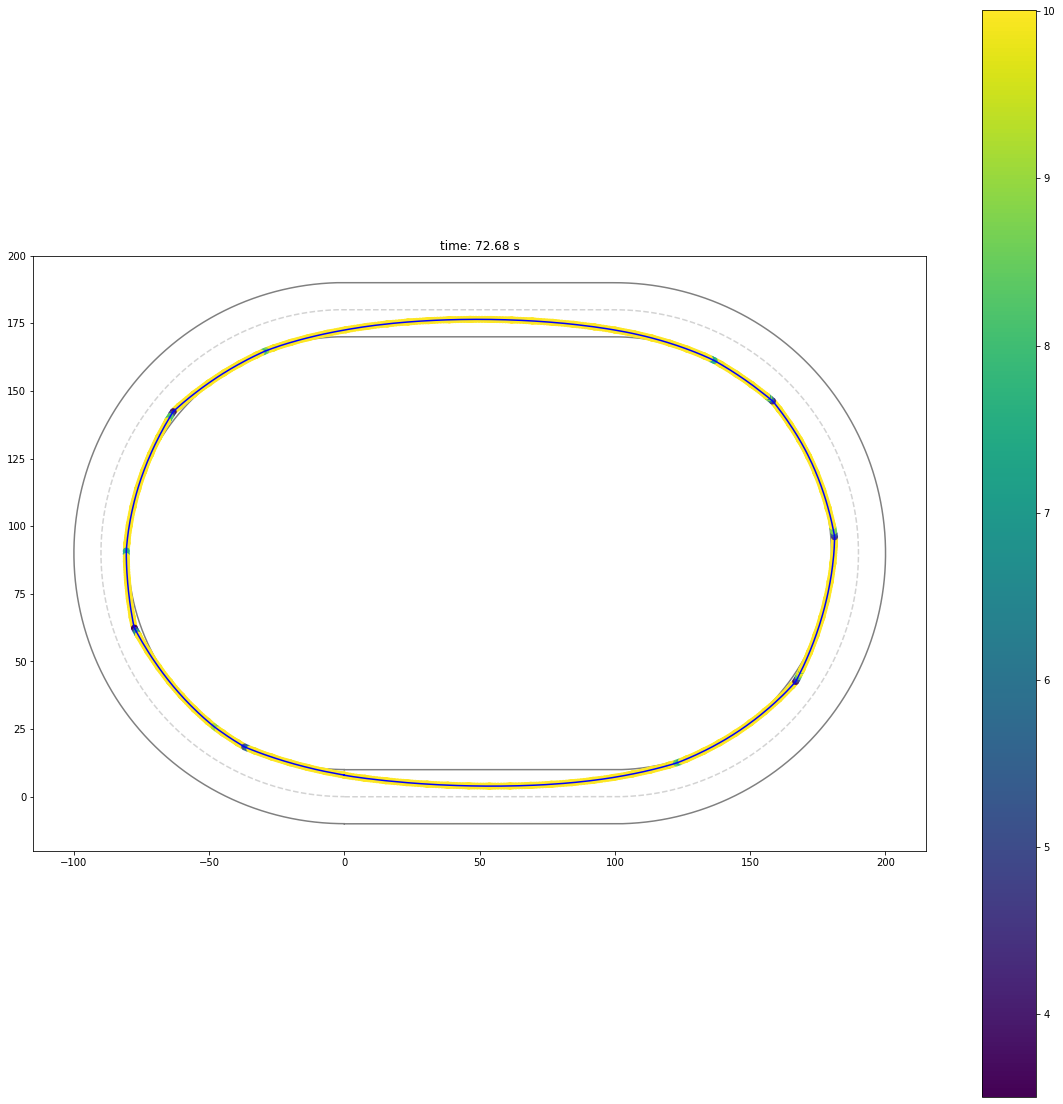

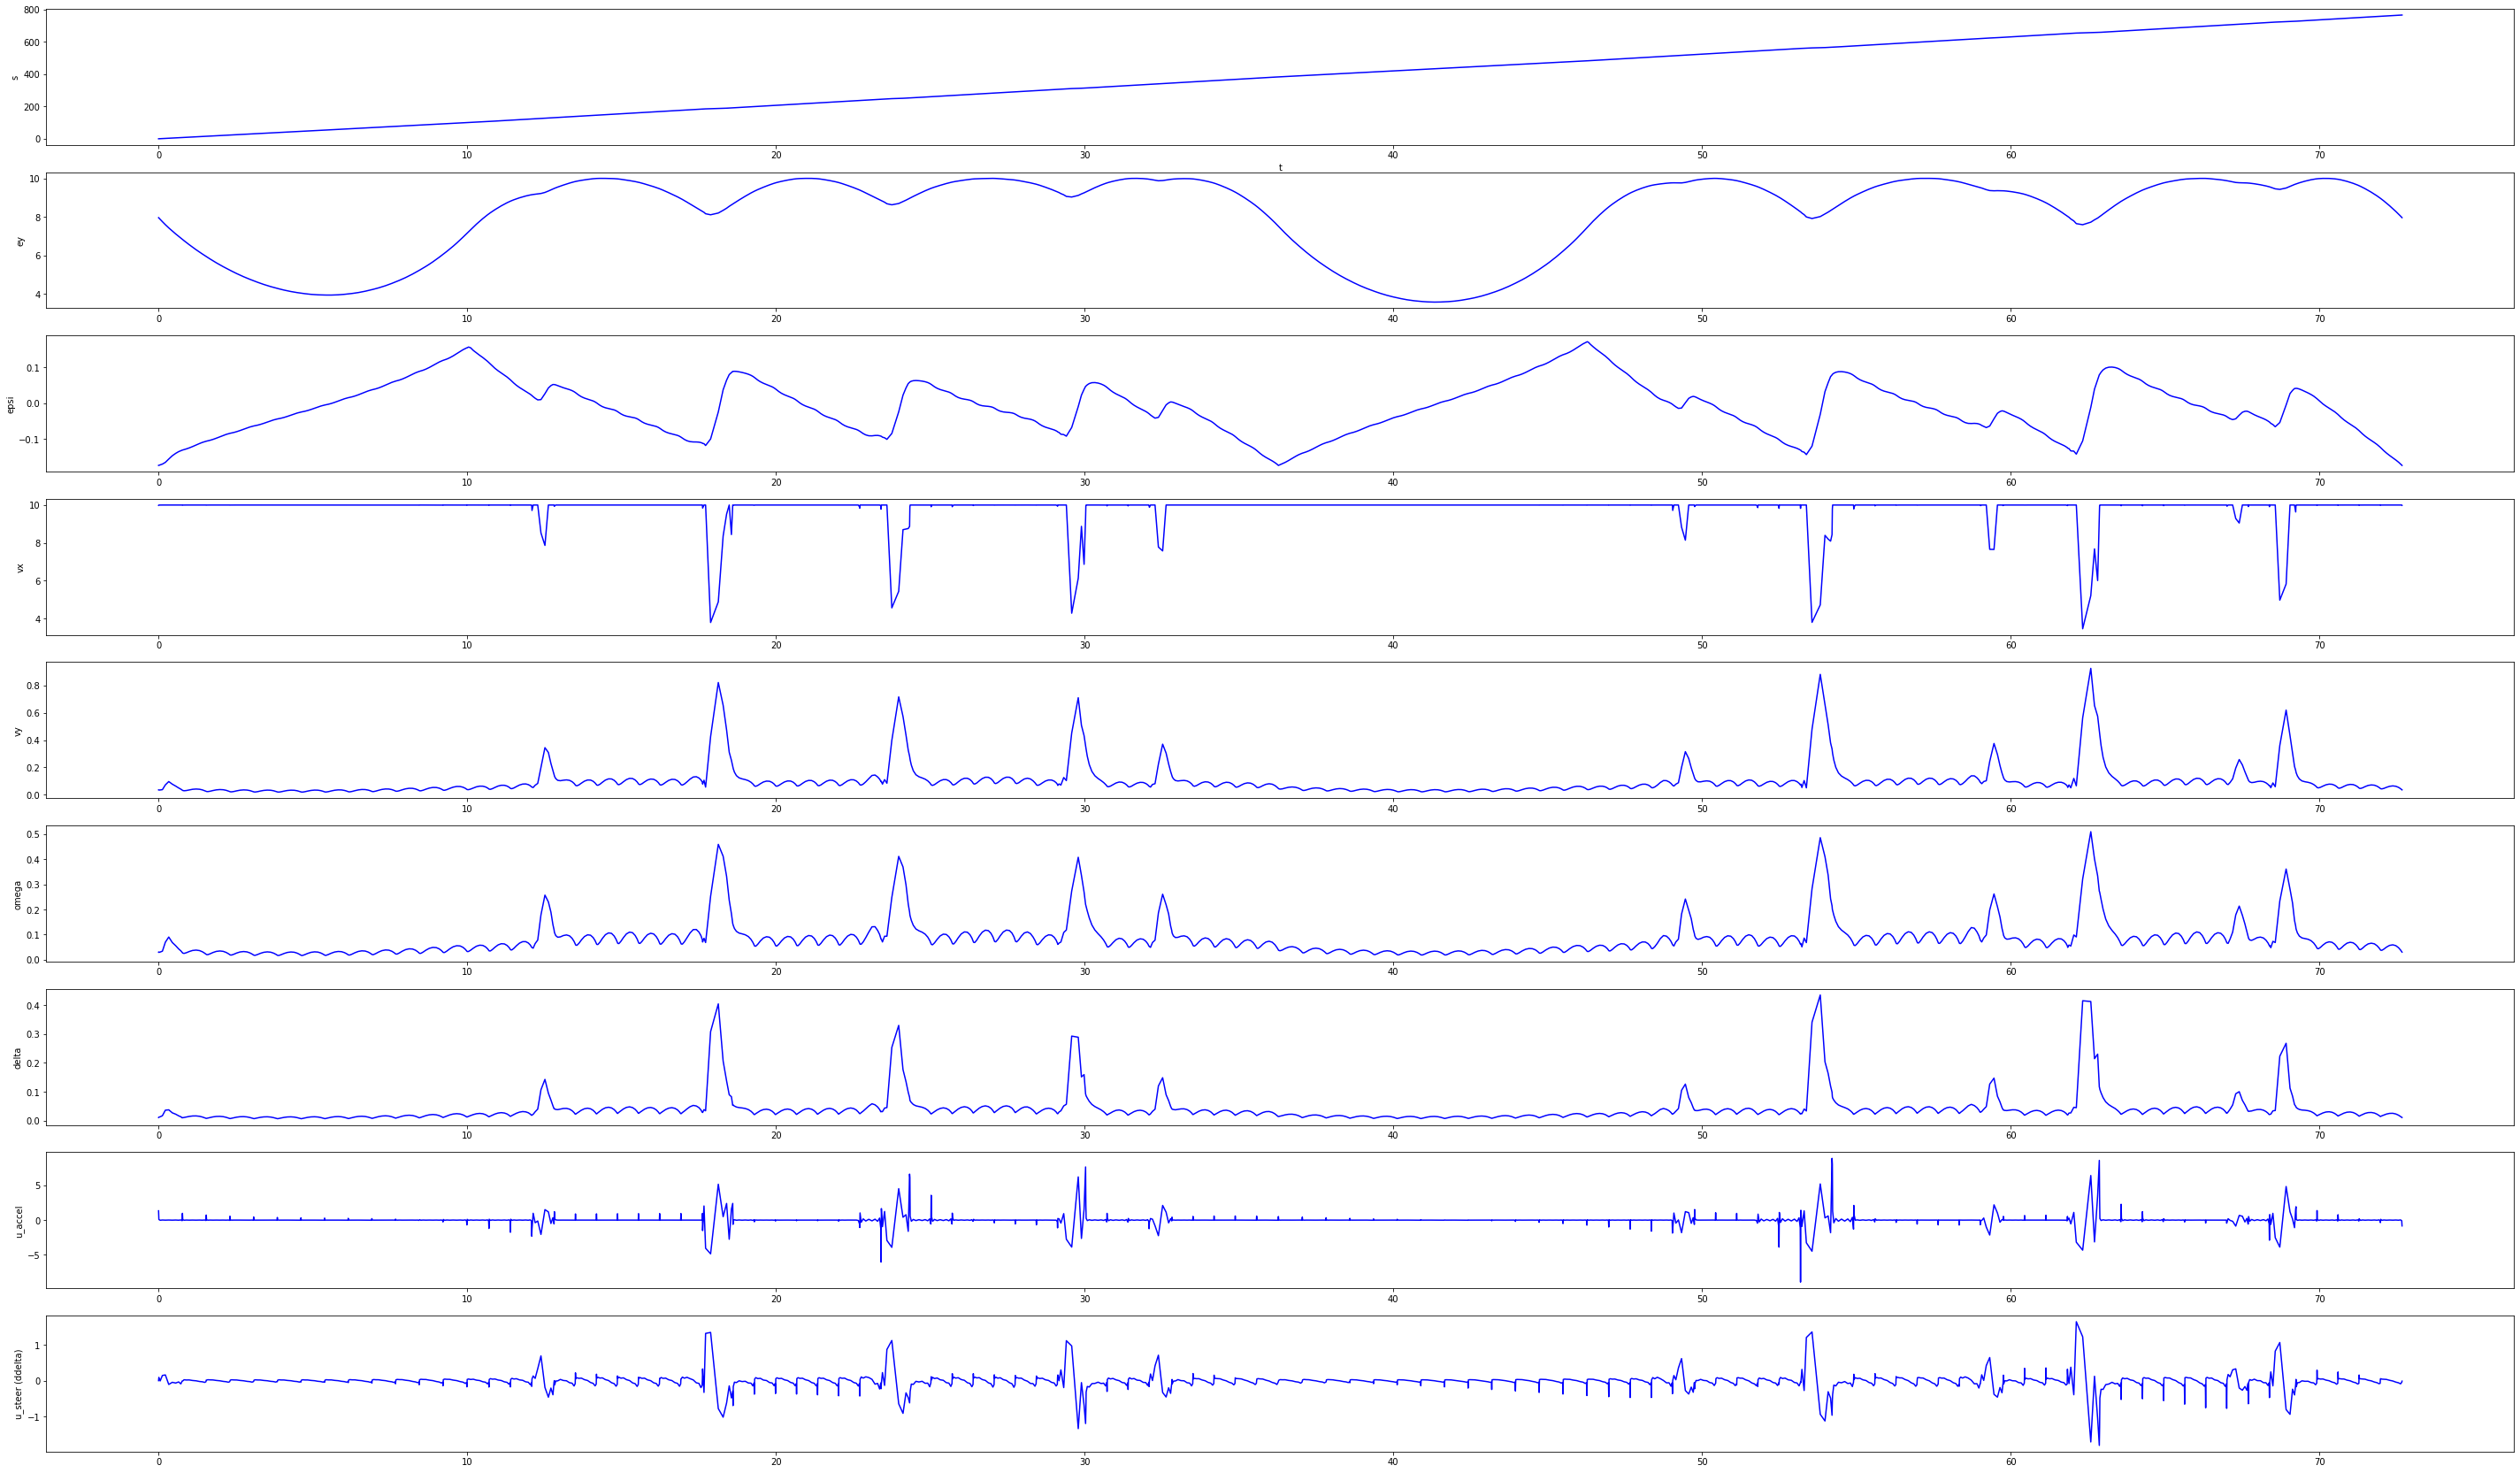

In [196]:
# Plot raceline
plot_racelines(track, raceline)

# Save raceline
# filename = 'raceline.npz'
# np.savez(filename, **raceline)

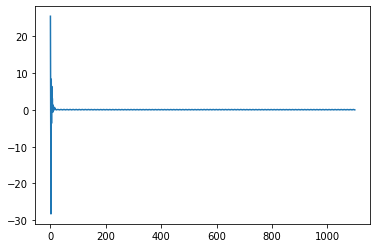

In [173]:
plt.plot(np.diff(raceline["t"]))